In [1]:
import os
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
key = 'eb5a92686ef949b79bd7662c179effce'

In [ ]:
results = search_images_bing(key, 'grizzly bear')

In [ ]:
ims = results.attrgot('contentUrl')

In [ ]:
ims[0]

In [ ]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

In [ ]:
im = Image.open(dest)
im.to_thumb(256, 256)

In [ ]:
?download_url

In [ ]:
bear_types = 'grizzly', 'black', 'teddy'

In [3]:
path = Path('bears')

In [ ]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [4]:
fns = get_image_files(path)

In [5]:
fns

(#420) [Path('bears/grizzly/0538ba7e-8eca-4b72-b665-99d22bf09d80.jpg'),Path('bears/grizzly/d80876a4-53ce-41d4-a103-30f1720c5fb5.jpg'),Path('bears/grizzly/36c565db-dd40-4641-a610-1390dc4aedd7.jpg'),Path('bears/grizzly/9e2f561d-97f4-46be-b629-59c21a68b22b.jpg'),Path('bears/grizzly/85a615df-5ea7-4c66-9f81-1e0d1f6b7115.jpg'),Path('bears/grizzly/7d76f093-e42d-472e-959b-ae7a26665f1b.jpg'),Path('bears/grizzly/46a1d932-8789-4f4c-8415-c326ce6c6fb8.jpg'),Path('bears/grizzly/d8c578a8-24f5-493e-9ba4-a829ba4f7e0f.jpg'),Path('bears/grizzly/9047bff7-2e75-4ed1-abf3-761183187b0b.jpg'),Path('bears/grizzly/4db658cc-ca33-4b93-ba4e-23bb5d55bbef.jpg')...]

In [6]:
failed = verify_images(fns)
failed

(#0) []

In [ ]:
??verify_images

In [ ]:
failed.map(Path.unlink)

In [ ]:
failed

In [7]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [8]:
dls = bears.dataloaders(path)

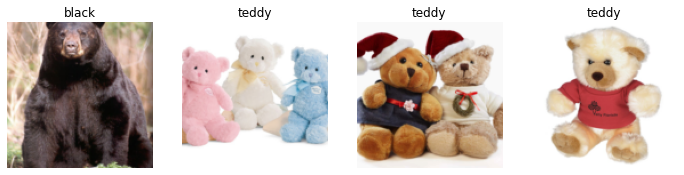

In [9]:
dls.valid.show_batch(max_n=4, nrows=1)

In [10]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))

In [11]:
dls = bears.dataloaders(path)

/Users/cchang/miniforge3/envs/nlp/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWarning: The operator 'aten::_linalg_solve_ex.result' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  ret = func(*args, **kwargs)


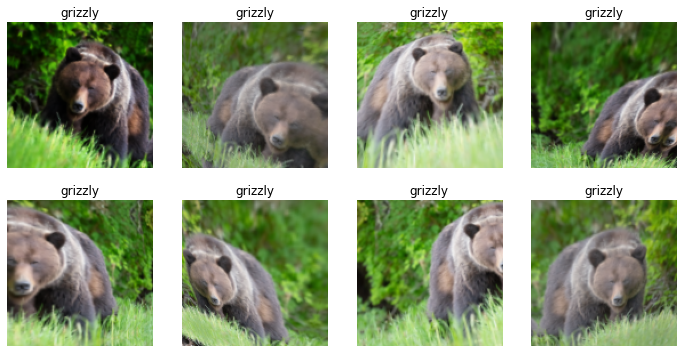

In [12]:
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [13]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

dls = bears.dataloaders(path)

In [14]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

/Users/cchang/miniforge3/envs/nlp/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/cchang/miniforge3/envs/nlp/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/cchang/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:03<00:00, 12.3MB/s]


In [15]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.213613,0.166571,0.047619,00:18


epoch,train_loss,valid_loss,error_rate,time
0,0.250191,0.142227,0.011905,00:19
1,0.172604,0.163270,0.011905,00:19
2,0.140349,0.178327,0.011905,00:19
3,0.111817,0.177545,0.011905,00:19


In [16]:
interp = ClassificationInterpretation.from_learner(learn)

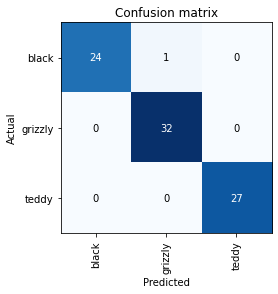

In [17]:
interp.plot_confusion_matrix()

In [19]:
interp.print_classification_report()

              precision    recall  f1-score   support

       black       1.00      0.96      0.98        25
     grizzly       0.97      1.00      0.98        32
       teddy       1.00      1.00      1.00        27

    accuracy                           0.99        84
   macro avg       0.99      0.99      0.99        84
weighted avg       0.99      0.99      0.99        84



In [20]:
interp.most_confused()

[('black', 'grizzly', 1)]

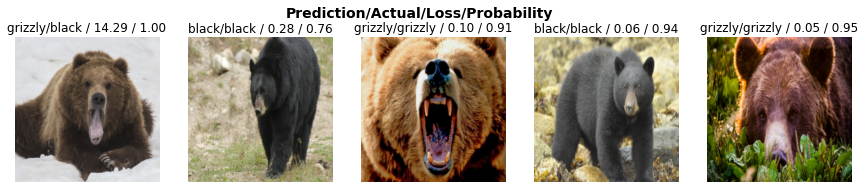

In [21]:
interp.plot_top_losses(5, nrows=1)

---

In [26]:
learn.export()

In [27]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [28]:
model = load_learner(path/'export.pkl')

In [29]:
model.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([1.3067e-05, 9.9997e-01, 1.7030e-05]))

In [30]:
model.dls.vocab

['black', 'grizzly', 'teddy']